# 6.1 RNN의 문제점

#### Tom was watching tv in his room, mary came into the room. mary said hi to ????

앞에서도 말했듯 "?"에 들어가는 단어는 "Tom"이다. RNN이 답을 하기 위해서는 "Tom이 방에서 TV를 보고 있음"과 "그 방에 Mary가 들어옴"이라는 정보를 기억해야 한다.
> 이런 정보를 RNN 계층의 은닉 상태에 인코딩해 보관 해둬야 한다.

![](https://images.velog.io/images/a01152a/post/db28d6c3-fd08-4f6c-9da6-ba99e0b6d8af/image.png)

기울기의 흐름을 보여주는 사진인데, RNN 계층이 과거 방향으로 '의미 있는 기울기'를 전달함으로써 시간 방향의 의존 관계를 학습할 수 있다. 문제는 RNN이 기울기를 과거로 전달함으로써 Gradient vanishing이 일어나거나 Gradient exploding이 발생한다는 것이다.

> RNN이 기본적으로 Activation function을 "tanh"로 쓰는 이유는 "sigmoid"보다 그나마 gradient에 덜민감하기 때문이다. 하지만 지속적으로 전달되면 vanishing을 피할 수 없다.
![](https://images.velog.io/images/a01152a/post/900f8386-87ec-4c03-aa9a-7907c21f0b13/image.png)

## 기울기 소실( vanishing gradient ), 기울기 폭발( exploding gradient )의 원인

![](https://images.velog.io/images/a01152a/post/41ca0051-ce2b-4224-9d84-3d64b2233f8b/image.png)

1. tanh의 미분값이 1.0이하이기 때문에 tanh 함수를 T번 통과하면 기울기도 T번 반복해서 작아지게 된다. **(Gradient vanishing)**
> RNN 계층의 활성화 함수로 **ReLU**로 바꾸면? 기울기 소실을 줄일 수 있다. 
이유는 Relu는 역전파시 상류의 기울기를 그대로 하류에 흘려보내기 때문이다. 기울기가 작아지지 않는다는 말!! (Improving performance of recurrent neural network with relu nonlinearity 논문을 참고)
2. tanh를 무시하고 'MatMul' 연산에 집중하면
![](https://images.velog.io/images/a01152a/post/f59eb13a-ef8f-41b6-9028-359155ff3a63/image.png)
상류에서 dh라는 기울기가 흘러오고 MatMul에서 dh * Wh.T라는 행렬곱으로 기울기를 계산한다. 이 계산을 반복하는데, **똑같은 가중치**가 사용된다는 것이다.


In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
N = 2 # 미니배치 크기
H = 3 # 은닉 상태 벡터의 차원 수
T = 20 # 시계열 데이터의 길이

dh = np.ones((N, H))
np.random.seed(3) # 재현할 수 있도록 난수의 시드 고정
Wh = np.random.randn(H, H)

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

print(norm_list)

[2.4684068094579303, 3.335704974161037, 4.783279375373183, 6.2795873320876145, 8.080776465019055, 10.25116303229294, 12.9360635066099, 16.276861327786712, 20.454829618345983, 25.688972842084684, 32.25315718048336, 40.48895641683869, 50.824407307019094, 63.79612654485427, 80.07737014308985, 100.51298922051251, 126.16331847536827, 158.3592064825883, 198.77107967611957, 249.495615421267]


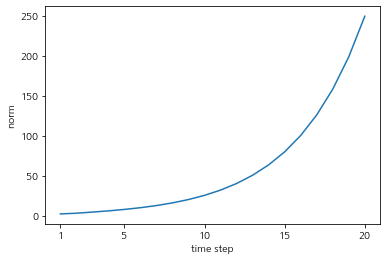

In [5]:
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

보듯 기울기의 크기가 급격히 증가하여 **Gradient exploding**이 발생한다. 이런 기울기 폭발이 일어나면 결국 오버플로를 일으켜 NaN(Not a Number)값을 발생시킨다. 

In [10]:
dh = np.ones((N, H))
np.random.seed(3) # 재현할 수 있도록 난수의 시드 고정
Wh = np.random.randn(H, H) * 0.5

norm_list = []
for t in range(T):
    dh = np.matmul(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

print(norm_list)

[1.2342034047289652, 0.8339262435402592, 0.5979099219216478, 0.3924742082554759, 0.25252426453184545, 0.16017442237957719, 0.10106299614538984, 0.06358148956166684, 0.039950839098332, 0.025086887541098325, 0.015748611904532892, 0.009884999125204758, 0.006204151282595104, 0.003893806551809953, 0.002443767399386287, 0.0015337065005571367, 0.0009625497320203268, 0.0006040924319556743, 0.00037912574706291117, 0.00023793756048323344]


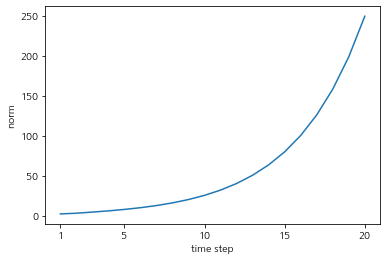

In [6]:
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('time step')
plt.ylabel('norm')
plt.show()

기울기가 급격히 감소하여 **Gradient vanishing**이 발생한다. 이로 인해 가중치 매개변수가 더 이상 갱신되지 않는다.

In [7]:
dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0

def clip_grads(grads, max_norm):
    norm_list = []
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)
    
    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate
    

print('before:', dW1.flatten())
clip_grads(grads, max_norm)
print('after', dW1.flatten())

before: [6.49144048 2.78487283 6.76254902 5.90862817 0.23981882 5.58854088
 2.59252447 4.15101197 2.83525082]
after [1.49503731 0.64138134 1.55747605 1.36081038 0.05523244 1.28709139
 0.59708178 0.95601551 0.65298384]


- 모든 매개변수에 대해 하나의 기울기로 처리한다고 가정하고, 이를 g^로 표기한다.
- threshold값을 문턱값으로 설정한다.
- 기울기의 L2노름 ||g^|| 이 문턱값 초과시 기울기를 수정한다.

# 6.2 기울기 소실과 LSTM

기울기 소실을 막기 위해 기존 RNN에서 게이트가 추가된 LSTM과 GRU가 있다. 지금부터 LSTM에 집중해서 구조를 살펴 본다.

![](https://images.velog.io/images/a01152a/post/e394716f-94a3-416a-9bf3-72311ca59659/image.png)

LSTM 계층의 인터페이스에는 c라는 경로가 있다. c를 **기억 셀**이라고 한다.

기억 셀의 특징은 데이터를 LSTM 계층 내에서만 주고 받는다는 것이다. 다른 계층으로는 출력하지 않는다는 것이다.

![](https://images.velog.io/images/a01152a/post/78a4f328-4829-4047-a0e6-8d5d61a97f70/image.png)

Ct을 사용해 은닉상태 ht를 구한다. 
계산은 ht= tanh(ct)인데, 이는 Ct의 각 요소에 tanh 함수를 적용한다.

## 게이트의 역할
![](https://images.velog.io/images/a01152a/post/8787f901-3858-4fa1-a17f-ea002d7ed02a/image.png)

앞으로 게이트를 사용하여, 위의 그림 처럼 데이터의 흐름을 제어한다. 

여기서 중요한 것은 '게이트를 얼마나 열까'라는 것도 데이터로부터 (자동으로) 학습한다.

> 게이트는 게이트의 열림 상태를 제어하기 위해서 전용 가중치 매개변수를 이용하여, 이 가중치 매개변수는 학습 데이터로부터 갱신된다. 참고로, 게이트의 열림 상태를 구할 때는 **시그모이드** 함수를 사용하는데, 시그모이드의 함수의 출력이 마침 0.0~1.0 사이의 실수이기 때문이다.

## output 게이트

tanh(Ct)에 게이트를 적용하는 것을 생각해보자.

![](https://images.velog.io/images/a01152a/post/979ff2c2-349f-403c-9cc6-630b9fbaf746/image.png)

tanh(Ct)는 각 원소에 대해**'그것이 다음 시각의 은닉 상태에 얼마나 중요한가'를 조정한다.**, 한편 이 게이트는 다음 은닉 상태 ht의 출력을 담당하는 게이트이므로 output 게이트(출력 게이트)라고 한다.

output 게이트의 열림 상태는 입력Xt와 이전 상태 ht-1로부터 구한다.
- 가중치 매개변수와 편향에는 output의 첫 글자인 o를 첨자로 추가한다.

![](https://images.velog.io/images/a01152a/post/5411b43c-151b-4590-8dd1-6620dd12448a/image.png)

ht는 o와 tanh(Ct)의 곱으로 계산된다. 여기서 말하는 '곱'이란 원소별 곱이며, 이것을 **아다마르 곱**이라고 한다.

![](https://images.velog.io/images/a01152a/post/ca190b4f-9ac1-40d0-9c18-6376fc72efee/image.png)

> 선형대수학에서, 아다마르 곱(영어: Hadamard product)은 같은 크기의 두 행렬의 각 성분을 곱하는 연산이다. 즉, 일반 행렬곱은 m x n과 n x p의 꼴의 두 행렬을 곱하지만, 아다마르 곱은 m x n 과 m x n의 꼴의 두 행렬을 곱한다.

## forget 게이트
망각은 더 나은 전진을 낳는다. 말 그대로 forget, '무엇을 잊을까'를 명확하게 지시하는 것이다.
![](https://images.velog.io/images/a01152a/post/890ef285-247b-4da0-9d34-f94bcc19c49c/image.png)

forget 게이트는 Ct-1의 기억 중에서 불필요한 기억을 잊게 해주는 게이트이다.
![](https://images.velog.io/images/a01152a/post/dfa95fbd-2c12-43e2-a576-30ab0662192d/image.png)

f를 구해서 **ct = f⊙ct-1**를 계산하면 된다.

## 새로운 기억 셀

forget으로 이전 시각의 기얼 셀로부터 잊어야 할 기억은 삭제 되었다. 그렇다면, 새로 기억해야 할 정보를 기억 셀에 추가해야 한다. 그림과 같이 tanh 노드를 추가한다.
![](https://images.velog.io/images/a01152a/post/3365f75e-8e6c-4ffb-abcc-9e69d2e9f0ed/image.png)

tanh 노드가 계산한 결과가 이전 시각의 기억 셀 Ct-1에 더해진다. 기억 셀의 새로운 '정보'가 추가 되는 것이다. 

이 tanh노드는 '게이트'가 아니며, 새로운 '정보'를 기억 셀에 추가하는 것이 목적이다. 따라서 활성화 함수로는 시그모이드 함수가 아닌 tanh 함수가 사용된다.

> tanh의 출력은 -1.0~1.0의 실수이다. 이 -1.0~1.0의 수치를 **그 안에 인코딩된 '정보'의 강약(정도)을 표시**한다고 해석할 수 있다.
한편 시그모이드 함수의 출력은 0.0~1.0의 실수이며, **데이터를 얼마만큼 통과시킬지를 정하는 비율**을 뜻한다. 
따라서 (주로) 게이트에서는 시그모이드 함수가, 실직적인 '정보'를 지나는 데이터에는 tanh 함수가 활성화 함수로 사용된다.

![](https://images.velog.io/images/a01152a/post/78c694b5-1a7d-4fb2-806a-744c97600de7/image.png)


## input 게이트

g에 게이트를 하나 추가해 보자. input 게이트는 g의 각 원소가 새로 추가되는 정보로써의 가치가 얼마나 큰지를 판단한다.(scaling)
<img src="https://images.velog.io/images/a01152a/post/c2ede8d5-22d3-4218-86fb-a415ec4ff1bd/image.png" height="100px" width="200px">

마치 수도 꼭지 처럼 현재 정보에서 찬물 더운물을 적당히 조절해주는 역할을 한다. (f는 과거 정보에 대한 수도꼭지)

![](https://images.velog.io/images/a01152a/post/7e0a67a8-dcac-473f-8732-bc5927080958/image.png)

정보를 적절히 취사선택하는 것이 input 게이트의 역할이다.
input 게이트에 의해 가중된 정보가 새로 추가되는 셈이다.

![](https://images.velog.io/images/a01152a/post/3ad8566c-8a99-45c5-9aa9-824c3a113bd3/image.png)

그 다음 ** i * g **를 구해서 기억 셀에 더하여 추가하면 된다.

## LSTM 기울기 흐름
![](https://images.velog.io/images/a01152a/post/ce1db0a6-dd17-405f-8978-07ef2a892cd4/%ED%99%94%EB%A9%B4%20%EC%BA%A1%EC%B2%98%202021-08-04%20183418.png)

기억 셀의 역전파에서는 '+'와 'x'노드만을 지난다.

'+'노드는 상류에서 전해지는 기울기를 그대로 흘릴 뿐이다.

'x'노드는 '행렬 곱'이 아닌 '원소별 곱(아마다르 곱)'을 계산한다.

매 시각 다른 게이트 값을 이용해 원소별 곱을 계산한다.

매번 새로운 게이트 값을 이용하므로 곱셈의 효과가 누적되지 않아 기울기 소실이 일어나지 않는(혹은 일어나기 힘든) 것이다.

'x' 노드의 계산은 forget 게이트가 제어한다.

forget 게이트가 '잊어야 한다'고 판단한 기억 셀의 원소에 대해서는 그 기울기가 작아진다.

'잊어서는 안된다'라고 판단한 원소에 대해서는 기울기가 약화되지 않고 과거 방향으로 전해진다.

# 6.3 LSTM 구현

<img src="https://images.velog.io/images/a01152a/post/9bacfd4c-2ebf-4941-89d8-f510fc5d4030/image.png" height="100px" width="400px">

게이트에서 수행하는 계산을 정리한 수식이다.
주목할 점은 수식에 포함된 **affine transformation**이다.
- affine transformation - 행렬 변환과 평행 이동(편향)을 결합한 형태 xWx + hWh + b 

이 덕분에 이 여러 식을 하나의 식으로 정리해 계산할 수 있다.
![](https://images.velog.io/images/a01152a/post/71ca95ea-d57b-4646-aa56-d0171d0c33be/image.png)

4번 계산할 것을 1회의 계산으로 끝마쳐 계산 속도가 빨라진다.

일반적으로 행렬 라이브러리는 '큰 행렬'을 한꺼번에 계산할 때가 각각을 계산할 때보다 빠르기 때문이다.

![](https://images.velog.io/images/a01152a/post/ca3849ab-c7e1-49c3-86d1-c6efd95163dd/image.png)


In [8]:
import sys
sys.path.append('..')
from common.functions import sigmoid
class LSTM:
    def __init(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
    
    def forward(self, x, h_prev, c_prev):
        # Wx = (D, 4H), Wh = (H, 4H)
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        
        A = np.matmul(x, Wx) + np.matmul(h_prev, Wh) + b
        
        # slice
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]
        
        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)
        
        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)
        
        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next
    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache
        
        tanh_c_next = np.tanh(c_next)
        ds = dc_next + (o * dh_next) * (1 - tanh_c_next ** 2)
        
        dc_prev = ds * f
        
        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i
        
        # sigmoid
        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2 )
        
        dA = np.hstack((df, dg, di, do))
        
        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev

# 6.3.1 Time LSTM 구현

Time LSTM은 T개분의 시계열 데이터를 한꺼번에 처리하는 계층이다.
![](https://images.velog.io/images/a01152a/post/a0dfc911-4237-46ce-8291-b86d7c9e0ea2/image.png)

역시 학습할 때 Truncated BPTT를 사용해 역전파의 연결 길이를 끊는다.

![](https://images.velog.io/images/a01152a/post/8616e679-436a-4d9e-ab45-95062fe4495f/image.png)

In [9]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful
        
    def forward(self, xs):
        Wx, Wh, b = self.params
        self.dh = None
        H = Wh.shape[0]
        
        self.layers = []
        hs = np.empty((N, T, H), dtpye = 'f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')
            
        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h
            
            self.layers.append(layer)
        
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]
        
        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0
        
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :]+ dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
                
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
            self.dh = dh
            return dxs
        
    def set_state(self, h, c=None):
        self.h, self.c = h, c
    
    def reset_state(self):
        self.h, self.c = None, None

# 6.4 LSTM을 사용한 언어 모델

LSTM을 사용한 언어 모델은 이전글인 **RNN을 사용한 언어 모델**과 굉장히 흡사하다.
![](https://images.velog.io/images/a01152a/post/593902fa-d2bf-4e37-a248-b049caef2010/image.png)

In [15]:
from common.time_layers import *
import pickle

class Rnnlm:
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.lstm_layer.reset_state()
        
    def save_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)
            
    def load_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)

| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 9999.69
| 에폭 1 |  반복 21 / 1327 | 시간 7[s] | 퍼플렉서티 2965.95
| 에폭 1 |  반복 41 / 1327 | 시간 15[s] | 퍼플렉서티 1249.66
| 에폭 1 |  반복 61 / 1327 | 시간 22[s] | 퍼플렉서티 962.55
| 에폭 1 |  반복 81 / 1327 | 시간 30[s] | 퍼플렉서티 796.55
| 에폭 1 |  반복 101 / 1327 | 시간 38[s] | 퍼플렉서티 661.68
| 에폭 1 |  반복 121 / 1327 | 시간 46[s] | 퍼플렉서티 651.81
| 에폭 1 |  반복 141 / 1327 | 시간 53[s] | 퍼플렉서티 589.56
| 에폭 1 |  반복 161 / 1327 | 시간 61[s] | 퍼플렉서티 585.20
| 에폭 1 |  반복 181 / 1327 | 시간 68[s] | 퍼플렉서티 579.40
| 에폭 1 |  반복 201 / 1327 | 시간 75[s] | 퍼플렉서티 508.90
| 에폭 1 |  반복 221 / 1327 | 시간 82[s] | 퍼플렉서티 498.41
| 에폭 1 |  반복 241 / 1327 | 시간 90[s] | 퍼플렉서티 444.40
| 에폭 1 |  반복 261 / 1327 | 시간 97[s] | 퍼플렉서티 482.82
| 에폭 1 |  반복 281 / 1327 | 시간 105[s] | 퍼플렉서티 450.57
| 에폭 1 |  반복 301 / 1327 | 시간 113[s] | 퍼플렉서티 396.99
| 에폭 1 |  반복 321 / 1327 | 시간 120[s] | 퍼플렉서티 344.93
| 에폭 1 |  반복 341 / 1327 | 시간 126[s] | 퍼플렉서티 412.85
| 에폭 1 |  반복 361 / 1327 | 시간 133[s] | 퍼플렉서티 409.24
| 에폭 1 |  반복 381 / 1327 | 시간 140[s] | 퍼플렉서티 340.70

| 에폭 3 |  반복 541 / 1327 | 시간 1177[s] | 퍼플렉서티 135.94
| 에폭 3 |  반복 561 / 1327 | 시간 1185[s] | 퍼플렉서티 118.87
| 에폭 3 |  반복 581 / 1327 | 시간 1192[s] | 퍼플렉서티 104.46
| 에폭 3 |  반복 601 / 1327 | 시간 1200[s] | 퍼플렉서티 147.07
| 에폭 3 |  반복 621 / 1327 | 시간 1208[s] | 퍼플렉서티 142.52
| 에폭 3 |  반복 641 / 1327 | 시간 1216[s] | 퍼플렉서티 129.56
| 에폭 3 |  반복 661 / 1327 | 시간 1229[s] | 퍼플렉서티 120.33
| 에폭 3 |  반복 681 / 1327 | 시간 1238[s] | 퍼플렉서티 100.43
| 에폭 3 |  반복 701 / 1327 | 시간 1250[s] | 퍼플렉서티 118.24
| 에폭 3 |  반복 721 / 1327 | 시간 1260[s] | 퍼플렉서티 126.13
| 에폭 3 |  반복 741 / 1327 | 시간 1270[s] | 퍼플렉서티 107.06
| 에폭 3 |  반복 761 / 1327 | 시간 1280[s] | 퍼플렉서티 103.88
| 에폭 3 |  반복 781 / 1327 | 시간 1290[s] | 퍼플렉서티 104.45
| 에폭 3 |  반복 801 / 1327 | 시간 1299[s] | 퍼플렉서티 115.37
| 에폭 3 |  반복 821 / 1327 | 시간 1309[s] | 퍼플렉서티 116.07
| 에폭 3 |  반복 841 / 1327 | 시간 1322[s] | 퍼플렉서티 115.04
| 에폭 3 |  반복 861 / 1327 | 시간 1331[s] | 퍼플렉서티 117.49
| 에폭 3 |  반복 881 / 1327 | 시간 1341[s] | 퍼플렉서티 105.27
| 에폭 3 |  반복 901 / 1327 | 시간 1351[s] | 퍼플렉서티 130.80
| 에폭 3 |  반복

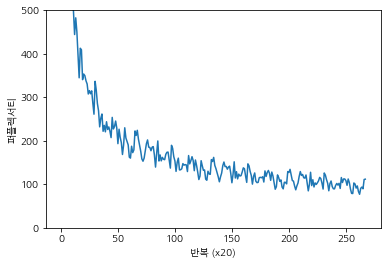

퍼플렉서티 평가 중 ...
234 / 235
테스트 퍼블렉서티:  136.39106711546


In [10]:
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb

# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100 # RNN의 은닉 상태 벡터의 원소 수
time_size = 35 # RNN을 펼치는 크기
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 기울기 클리핑을 적용하여 학습
# xs = 20 * 35
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
trainer.plot(ylim=(0, 500))

# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼블렉서티: ', ppl_test)

# 매개변수 저장
model.save_params()

# 6.5 RNNLM 추가 개선

1. LSTM 계층 다층화
2. 드롭아웃에 의한 과적합 억제
3. 가중치 공유
이 3가지가 RNNLM을 개선할 수 있는 포인트이다.

</br>

## LSTM 계층 다층화

![](https://images.velog.io/images/a01152a/post/ae44c8e2-ea51-4aa6-87aa-a1306a12036a/image.png)
LSTM 계층을 깊게 쌓아 효과를 볼 수 있다.

위 그림은 LSTM 계층을 두 개 쌓은 모습이다.
첫 번째 LSTM 계층의 은닉 상태가 LSTM 계층에 입력된다. 이와 같은 요령으로 LSTM 계층을 몇 층이라도 쌓을 수 있으며, 그 결과 더 복잡한 패턴을 학습할 수 있다.

다층화를 할 때 주의할 점은 하이퍼파라미터에 관한 문제이다. 복잡도나, 준비된 학습 데이터의 양에 따라 하이퍼파라미터를 적절하게 결정해야 한다. 
> PTB 데이터셋의 언어 모델에서는 LSTM의 층 수는 2~4에서 좋은 성능을 보인다.
구글 번역에 사용되는 GNMT 모델은 LSTM을 8층이나 쌓은 신경망이다. 
처리할 문제가 복잡하고 학습 데이터를 대량으로 준비한다면, LSTM 계층을 '깊게' 쌓는 것이 정확도 향상을 이끌 수 있다.

</br>

## 드롭아웃에 의한 과적합 억제

LSTM을 다층화하면 표현력이 풍부한 모델을 만들 수 있다. 하지만 이런 모델은 종종 **과적합(overfitting)**이 일어난다.

특히 RNN은 일반적인 피드포워드 신경망보다 쉽게 과적합을 일으킨다.

우리는 과적합을 줄이는 여러가지 방법을 알고 있다. '훈련 데이터의 양 늘리기'와 '모델의 복잡도 줄이기'가 있다. 그 외에 복잡도에 페널티를 주는 정규화(normalization)도 효과적이다.

**드롭아웃(dropout)**처럼 활성화 함수 뒤에 삽입하여 훈련 시 계층 내 뉴런 몇개를 무작위로 비활성하는 방법도 있다.

![](https://images.velog.io/images/a01152a/post/ca2197cf-ff6c-4439-b21d-d2aee0d87915/image.png)

RNN을 사용한 모델에는 드롭아웃을 어디에 넣어야 할까? 

첫 번째로, LSTM의 시계열 방향으로 삽입하는 것이다. 하지만 이것은 좋은 방법이 아니다.

시계열 방향으로 드롭아웃을 넣으면 (학습 시) 시간이 흐름에 따라 정보가 사라질 수 있다. 즉, 흐르는 시간에 비례해 드롭아웃에 의한 노이즈가 축적된다. 

![](https://images.velog.io/images/a01152a/post/1930a83c-603b-40c8-81c4-355734ded110/image.png)

이렇게 구성하면, 시간 방향(좌우 방향)으로 진행해도 정보를 잃지 않는다. 

하지만 최근 연구에서 RNN의 시간 방향 정규화 즉 **변형 드롭아웃**을 제안하고, 시간 방향으로 적용하는데 성공했다.

같은 계층에 속한 드롭아웃들은 같은 마스크를 공유한다. 

마스크란 데이터의 '통과/차단'을 결정하는 이진 형태의 무작위 패턴이다.
![](https://images.velog.io/images/a01152a/post/8627bcf5-54ba-4044-ba8d-547a2c8c20eb/image.png)

</br>

## 가중치 공유
언어 모델을 개선하는 아주 간단한 트릭 중 **가중치 공유**가 있다. 

![](https://images.velog.io/images/a01152a/post/54957a94-f597-42ac-88a1-e7e098e2a311/image.png)

두 계층의 가중치를 연결하여, 공유함으로써 학습하는 매개변수의 수가 크게 줄어드는 동시에 정확도도 향상되는 일석이조의 기술이다.

어휘 수를 V, LSTM의 은닉 상태의 차원수를 H라 할 때, Embedding 계층의 가중치는 형상이 V X H이며, Affine 계층의 가중치 형상은 H X V가 된다. 이때 가중치 공유를 적용하려면 가중치 전치를 사용해 설정하면 된다.

> 가중치 공유가 효과가 있는 이유는 직관적으로는 가중치를 공유함으로써 학습해야할 매개변수 수를 줄일 수 있고, 그 결과 학습하기가 더 쉬워지기 때문이다. 게다가 매개변수 수가 줄어든다 함은 과적합이 억제되는 혜택으로 이어질 수 있다.

</br>

In [11]:
class TimeDropout:
    def __init__(self, dropout_ratio=0.5):
        self.params, self.grads = [], []
        self.dropout_ratio = dropout_ratio
        self.mask = None
        self.train_flg = True

    def forward(self, xs):
        if self.train_flg:
            flg = np.random.rand(*xs.shape) > self.dropout_ratio
            scale = 1 / (1.0 - self.dropout_ratio)
            self.mask = flg.astype(np.float32) * scale

            return xs * self.mask
        else:
            return xs

    def backward(self, dout):
        return dout * self.mask

- TimeDropout도 기존 Dropout과 같다.
- 몇개를 비활성(0값)으로 만드는 대신 남아 있는 값은 scale 만큼 곱해주어 값을 유지하도록 한다.

In [12]:
from common.time_layers import *
from common.np import *
from common.base_model import BaseModel

class BetterRnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=650, hidden_size=650, dropout_ratio=0.5):
        V, D, H =vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4 * H).astype('f')
        lstm_Wx2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_Wh2 = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4 * H).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b)  # weight tying!!
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]
        
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
        
    def predict(self, xs, train_flg=False):
        for layer in self.drop_layers:
            layer.train_flg = train_flg
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()